# Detector de email Spam versión 2 con nuevos datos incorporados para mejorar el modelo

**Importación de librerías necesarias:**

In [1]:
!pip install wordcloud

In [2]:
import pandas as pd
import nltk # Para la PLN
import re # Librería para expresiones regulares
import nltk # Librería para PLN
from nltk.corpus import stopwords # Para la lista de stopwords
from nltk.stem import PorterStemmer # Para el stemming
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, precision_score, make_scorer, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
from collections import Counter
from scipy.sparse import hstack 
from sklearn.model_selection import learning_curve

In [3]:
# --- Descargas de NLTK (¡Ejecutar solo la primera vez que se use este entorno!) ---
# Una vez descargados, se pueden comentar estas líneas.
# Si ya los descargaste, no es necesario ejecutar esta celda de nuevo.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carme\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. DATA WRANLING

**Vamos a leer los datos con pandas en un df, ver las primeras 5 filas del mismo y otros datos de interés, también haremos un conteo de nulls.**

In [5]:
# Leemos los datos del csv con read_csv e imprimimos las primeras cinco filas con head()
df = pd.read_csv('spam_dataset.csv', encoding='latin-1')
print("Primeras 5 filas del dataset:")
print(df.head())
# Obtenemos información resumida con info()
print("\nInformación del DataFrame:")
print(df.info())
# Imprimimos el número total de valores faltantes por columna
print("\nValores nulos por columna:")
print(df.isnull().sum())

Primeras 5 filas del dataset:
                                                text     label
0  Go until jurong point, crazy.. Available only ...  not_spam
1                      Ok lar... Joking wif u oni...  not_spam
2  Free entry in 2 a wkly comp to win FA Cup fina...      spam
3  U dun say so early hor... U c already then say...  not_spam
4  Nah I don't think he goes to usf, he lives aro...  not_spam

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15831 entries, 0 to 15830
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15831 non-null  object
 1   label   15831 non-null  object
dtypes: object(2)
memory usage: 247.5+ KB
None

Valores nulos por columna:
text     0
label    0
dtype: int64


In [6]:
df.head(10)

,text,label
0,"Go until jurong point, crazy.. Available only ...",not_spam
1,Ok lar... Joking wif u oni...,not_spam
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,not_spam
4,"Nah I don't think he goes to usf, he lives aro...",not_spam
5,FreeMsg Hey there darling it's been 3 week's n...,spam
6,Even my brother is not like to speak with me. ...,not_spam
7,As per your request 'Melle Melle (Oru Minnamin...,not_spam
8,WINNER!! As a valued network customer you have...,spam
9,Had your mobile 11 months or more? U R entitle...,spam


In [7]:
df.columns

Index(['text', 'label'], dtype='object')

In [8]:
df.describe()

,text,label
count,15831,15831
unique,15831,2
top,"Go until jurong point, crazy.. Available only ...",not_spam
freq,1,9678


**Comprobamos que los datos están en el formato que queremos:**

In [9]:
df.dtypes

text     object
label    object
dtype: object

**Comprobamos que no haya filas dupilcadas:**

In [10]:
df.duplicated().sum()

np.int64(0)

## **Manejo de Etiquetas/Categorías (Label/Category Handling)**

In [11]:
# Mapear las etiquetas 'ham' y 'spam' a valores numéricos (0 y 1)
# 'ham' (no spam) será 0, 'spam' será 1
df['label'] = df['label'].map({'not_spam': 0, 'spam': 1})

# Muestra las primeras filas del DataFrame después de los cambios
print("DataFrame después de eliminar columnas, renombrar y mapear etiquetas:")
print(df.head())

# Muestra la distribución de las etiquetas para ver si hay desequilibrio
print("\nDistribución de etiquetas (0=not_spam, 1=spam):")
print(df['label'].value_counts())

DataFrame después de eliminar columnas, renombrar y mapear etiquetas:
                                                text  label
0  Go until jurong point, crazy.. Available only ...      0
1                      Ok lar... Joking wif u oni...      0
2  Free entry in 2 a wkly comp to win FA Cup fina...      1
3  U dun say so early hor... U c already then say...      0
4  Nah I don't think he goes to usf, he lives aro...      0

Distribución de etiquetas (0=not_spam, 1=spam):
label
0    9678
1    6153
Name: count, dtype: int64


## **Limpieza y Preprocesamiento de Texto (Text Cleaning & Preprocessing) - Especialmente para NLP**

En esta sección crucial, nos centramos en la columna `text` para aplicar una serie de técnicas de **Procesamiento del Lenguaje Natural (PLN)**.  
El objetivo es transformar el texto crudo en un formato limpio y estandarizado, optimizado para el análisis de Machine Learning.  
Este proceso de limpieza ayuda a reducir el "ruido" en los datos y permite que nuestro modelo se enfoque en las palabras más significativas y discriminatorias.

Los pasos de preprocesamiento aplicados a cada mensaje son los siguientes:

1.  **Conversión a Minúsculas:** Estandarizamos todo el texto a minúsculas para tratar palabras como "Spam" y "spam" como la misma entidad.
2.  **Eliminación de Puntuación y Caracteres Especiales:** Removemos cualquier carácter que no sea alfabético o un espacio, como signos de puntuación, números o símbolos, ya que generalmente no aportan valor predictivo en este contexto.
3.  **Tokenización y Eliminación de Stopwords:** Dividimos los mensajes en palabras individuales (tokenización) y luego filtramos las "stopwords" (palabras muy comunes como "el", "la", "y", "es") que, aunque frecuentes, no suelen tener poder discriminatorio para identificar spam.
4.  **Stemming:** Reducimos las palabras a su raíz o "stem" (por ejemplo, "corriendo", "corrió", "correr" se reducen a "corr"). Esto ayuda a agrupar variaciones de la misma palabra, reduciendo la dimensionalidad y aumentando la capacidad del modelo para reconocer patrones.

Finalmente, el texto limpio y procesado se almacena en una nueva columna llamada `clean_text` para su posterior uso.

In [12]:
# --- Inicializa las herramientas de NLTK ---
stemmer = PorterStemmer() # Usaremos el Porter Stemmer, es un estándar
stop_words = set(stopwords.words('english')) # Carga la lista de stopwords en inglés

# --- Función de preprocesamiento de texto ---
# Esta función limpia el texto de los mensajes SMS.
def preprocess_text(text):
    # Asegurarse de que el input es una cadena de texto
    if not isinstance(text, str):
        return "" # O manejar el error de otra forma, por ejemplo, levantando una excepción

    # 1. Convertir a minúsculas
    text = text.lower()

    # 2. Eliminar puntuación y caracteres especiales (y números)
    # [^a-zA-Z\s] significa: cualquier cosa que NO sea una letra (a-z, A-Z) o un espacio en blanco (\s)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) # Reemplazamos con un espacio para no juntar palabras

    # 3. Eliminar espacios extra (múltiples espacios, o al principio/final)
    text = re.sub(r'\s+', ' ', text).strip() # Reemplaza múltiples espacios con uno solo y quita espacios de inicio/fin

    # 4. Tokenizar el texto (dividirlo en palabras) y eliminar stopwords
    words = text.split() # Divide la cadena en una lista de palabras por espacios
    filtered_words = [word for word in words if word not in stop_words]

    # 5. Aplicar Stemming a cada palabra
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    # 6. Unir las palabras procesadas de nuevo en una sola cadena de texto
    return ' '.join(stemmed_words)

# --- Aplica la función de preprocesamiento ---
# Asegúrate de que tu DataFrame 'df' esté cargado.
# Por ejemplo: df = pd.read_csv('spam_dataset.csv', encoding='utf-8')

# Aplica la función de preprocesamiento a cada mensaje en la columna 'text'
# El resultado se guardará en una nueva columna llamada 'clean_text'
df['clean_text'] = df['text'].apply(preprocess_text)

# Muestra una comparación entre el mensaje original y el mensaje limpio para las primeras filas
print("Comparación de mensajes originales y limpios (Primeras 5 filas):")
print(df[['text', 'clean_text']].head(10))

Comparación de mensajes originales y limpios (Primeras 5 filas):
                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   
5  FreeMsg Hey there darling it's been 3 week's n...   
6  Even my brother is not like to speak with me. ...   
7  As per your request 'Melle Melle (Oru Minnamin...   
8  WINNER!! As a valued network customer you have...   
9  Had your mobile 11 months or more? U R entitle...   

                                          clean_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri wkli comp win fa cup final tkt st m...  
3                u dun say earli hor u c alreadi say  
4               nah think goe usf live arou

## 2. FEATURE ENGINEERING (Ingeniería de Características)

#### Vectorización de Texto con TF-IDF (Unigramas) 🔢

Una vez que los mensajes han sido limpiados, necesitamos convertirlos en un formato numérico que nuestros modelos de Machine Learning puedan entender. Para esto, utilizaremos la técnica **TF-IDF (Term Frequency-Inverse Document Frequency)**.

TF-IDF es una medida estadística que refleja la importancia de una palabra en un documento en relación con una colección o corpus de documentos. Las palabras comunes en muchos documentos (como "el", "la", "y"), que ya hemos eliminado como stopwords, tendrán un TF-IDF bajo, mientras que las palabras que son frecuentes en un documento específico pero raras en el resto del corpus (como "oferta" en un SMS de spam) tendrán un TF-IDF alto.

En este paso:

1.  **Inicializamos `TfidfVectorizer`:** Configuramos el vectorizador para considerar hasta **5000 características** (las palabras más relevantes) para limitar la dimensionalidad y mejorar el rendimiento.
2.  **Ajustamos y Transformamos los Datos:** El vectorizador aprende el vocabulario del conjunto de mensajes limpios (`clean_text`) y luego los transforma en una matriz numérica. Cada fila de esta matriz representará un mensaje y cada columna, una palabra con su peso TF-IDF correspondiente.

In [13]:
# Inicializa el TfidfVectorizer
# max_features=5000 limita el vocabulario a las 5000 palabras más importantes/frecuentes.
# Esto ayuda a controlar la dimensionalidad y mejora el rendimiento del modelo.
vectorizer = TfidfVectorizer(max_features=5000)

# Ajusta el vectorizador a tus mensajes limpios (clean_message)
# y los transforma en una matriz TF-IDF.
# X será una matriz dispersa (sparse matrix) donde cada fila es un mensaje
# y cada columna representa una palabra con su peso TF-IDF.
X = vectorizer.fit_transform(df['clean_text'])

# Tu variable objetivo (las etiquetas spam/ham, que ya son 0 y 1)
y = df['label']

print("Forma de la matriz TF-IDF (número de mensajes, número de características/palabras):")
print(X.shape)

print("\nEjemplo de las primeras 20 características (palabras) generadas por el vectorizador:")
# .get_feature_names_out() te da el listado de las palabras que el vectorizador aprendió
print(vectorizer.get_feature_names_out()[:20])

Forma de la matriz TF-IDF (número de mensajes, número de características/palabras):
(15831, 5000)

Ejemplo de las primeras 20 características (palabras) generadas por el vectorizador:
['aa' 'ab' 'abbrv' 'abc' 'abil' 'abiola' 'abl' 'abnorm' 'abort' 'absolut'
 'abstract' 'abt' 'abund' 'abus' 'ac' 'academ' 'academi' 'academictorr'
 'acc' 'acceler']


## 3. DATA VISUALIZATIONS

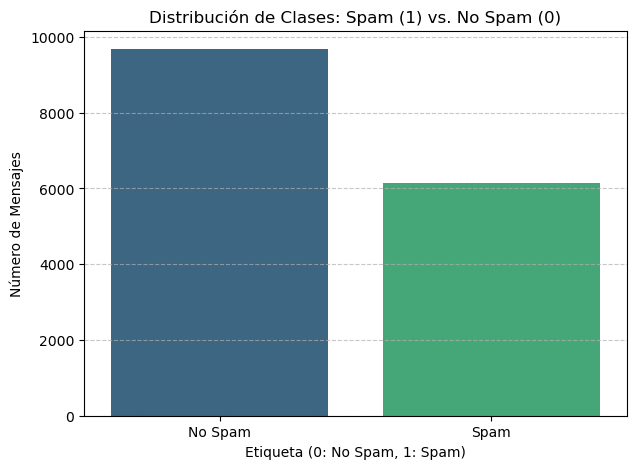

In [14]:
# --- 1. Visualización de la Distribución de Clases (Spam vs. No Spam) ---
plt.figure(figsize=(7, 5))
sns.countplot(x='label', data=df, palette='viridis', hue='label', legend=False)
plt.title('Distribución de Clases: Spam (1) vs. No Spam (0)')
plt.xlabel('Etiqueta (0: No Spam, 1: Spam)')
plt.ylabel('Número de Mensajes')
plt.xticks(ticks=[0, 1], labels=['No Spam', 'Spam']) # Etiquetas más claras en el eje X
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Hallazgos Clave:**

Observamos que el dataset presenta un desequilibrio de clases moderado. Hay aproximadamente 9600 mensajes clasificados como "No Spam" frente a unos 6100 mensajes clasificados como "Spam".

La clase "No Spam" es la clase mayoritaria.

**Implicaciones para la Evaluación del Modelo:**

Este desequilibrio significa que la precisión (accuracy) por sí sola no será una métrica fiable para evaluar el rendimiento de nuestro modelo. Un modelo podría lograr una alta precisión simplemente prediciendo la clase mayoritaria.
Por lo tanto, será crucial utilizar métricas más robustas como el **Recall**, la **Precision**, el **F1-Score** y la **Matriz de Confusión** para obtener una imagen real del rendimiento del modelo, especialmente en la detección de la clase minoritaria ("Spam").

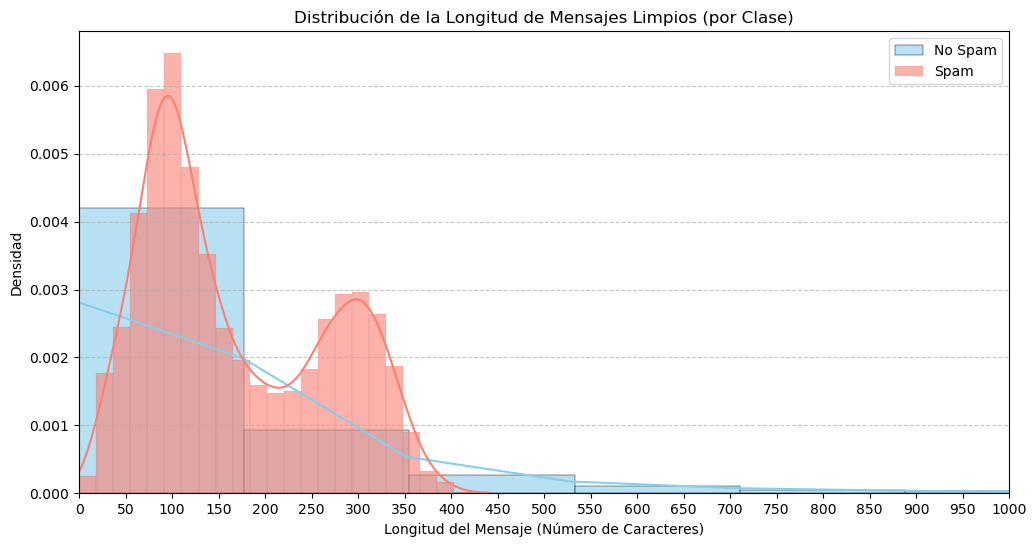

In [15]:
# --- 2. Visualización de la Longitud de los Mensajes ---
# Primero, calculamos la longitud de los mensajes limpios
df['clean_text_length'] = df['clean_text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df[df['label'] == 0]['clean_text_length'], color='skyblue', label='No Spam', kde=True, stat='density', alpha=0.6)
sns.histplot(df[df['label'] == 1]['clean_text_length'], color='salmon', label='Spam', kde=True, stat='density', alpha=0.6)
plt.title('Distribución de la Longitud de Mensajes Limpios (por Clase)')
plt.xlabel('Longitud del Mensaje (Número de Caracteres)')
plt.ylabel('Densidad')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# --- ¡CORRECCIÓN AQUÍ! Ajustar el rango del eje X y los ticks ---
plt.xlim(0, 1000) # Limitar el eje X de 0 a 5000
plt.xticks(np.arange(0, 1001, 50)) # Ticks cada 500 para no saturar, o cada 50 si quieres más detalle
# Si quieres cada 50, sería: plt.xticks(np.arange(0, 5001, 50))
# Pero con 500 ya se ve muy bien y no se superponen los números.

plt.show()

**Patrones de Comportamiento:**

- **Dominio de Mensajes Cortos en "No Spam":**

La distribución de los mensajes "No Spam" (azul) muestra un pico extremadamente alto y estrecho muy cerca del origen (0 caracteres). Esto indica que la gran mayoría de los mensajes legítimos son muy concisos y breves, a menudo por debajo de los 100 caracteres. La densidad cae drásticamente a medida que la longitud aumenta.

- **Patrón de Longitud Bimodal en "Spam":**

Un primer pico significativo también en longitudes cortas (similar al no-spam, ya que hay spam muy corto como "GRATIS!").
Sin embargo, lo más distintivo es un segundo pico o una distribución más extendida y densa en el rango de aproximadamente 150 a 400 caracteres. Esto sugiere que una proporción considerable de mensajes de spam son de longitud media, ya que necesitan incluir más detalles, ofertas, enlaces, números de contacto, o instrucciones para la estafa.

La clara separación y los diferentes perfiles de densidad entre ambas clases confirman que la longitud del mensaje es una característica extremadamente potente para diferenciar entre spam y no-spam.

Un mensaje muy corto (ej., menos de 100 caracteres) es altamente probable que sea no-spam.

Un mensaje que cae en el rango de 150 a 400 caracteres tiene una probabilidad significativamente mayor de ser spam que no-spam, ya que en ese rango la densidad de spam es considerablemente más alta que la de no-spam.

En resumen: Esta visualización no solo valida la idea de que la longitud es importante, sino que nos da una comprensión granular de cómo la longitud difiere entre las clases. Esto refuerza aún más la decisión de añadir la longitud del mensaje como una característica numérica explícita a nuestro modelo, ya que le proporcionará una señal muy fuerte para la clasificación que el TF-IDF por sí solo no capturaría de la misma manera.


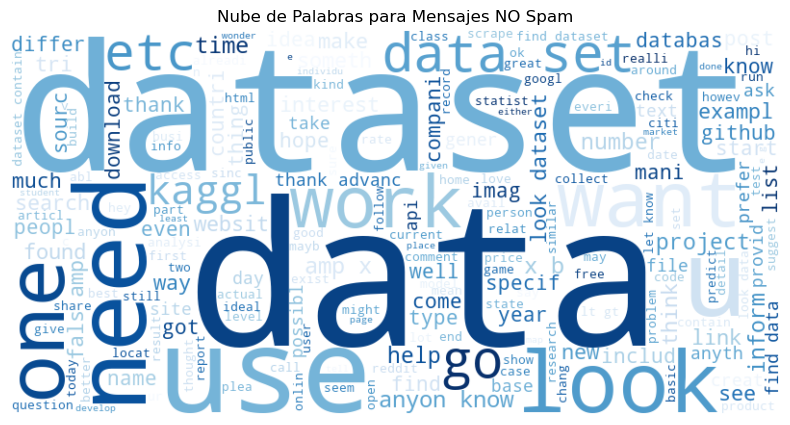

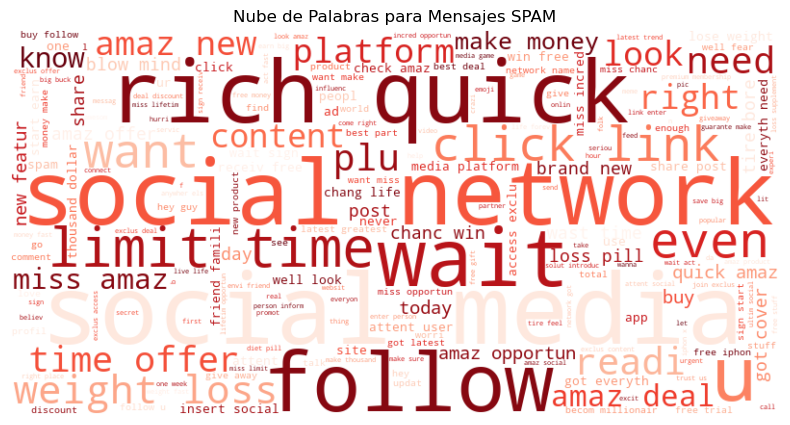

In [16]:
# --- 3. Nubes de Palabras (Word Clouds) para Spam y No Spam ---

# Concatenar todo el texto limpio para cada clase
text_not_spam = " ".join(df[df['label'] == 0]['clean_text'].astype(str))
text_spam = " ".join(df[df['label'] == 1]['clean_text'].astype(str))
# Crear y mostrar la Nube de Palabras para No Spam
wordcloud_not_spam = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(text_not_spam)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_not_spam, interpolation='bilinear')
plt.title('Nube de Palabras para Mensajes NO Spam')
plt.axis('off')
plt.show()

# Crear y mostrar la Nube de Palabras para Spam
wordcloud_spam = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_spam)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Nube de Palabras para Mensajes SPAM')
plt.axis('off')
plt.show()

Efectivamente comprobamos que las palabras típicas de los mensajes de spam aparecen en esta gráfica.

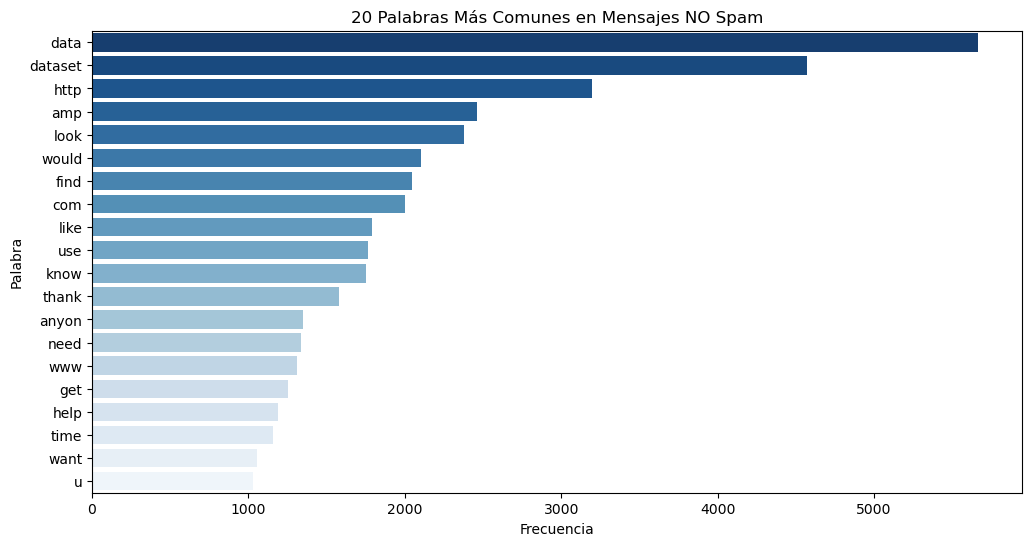

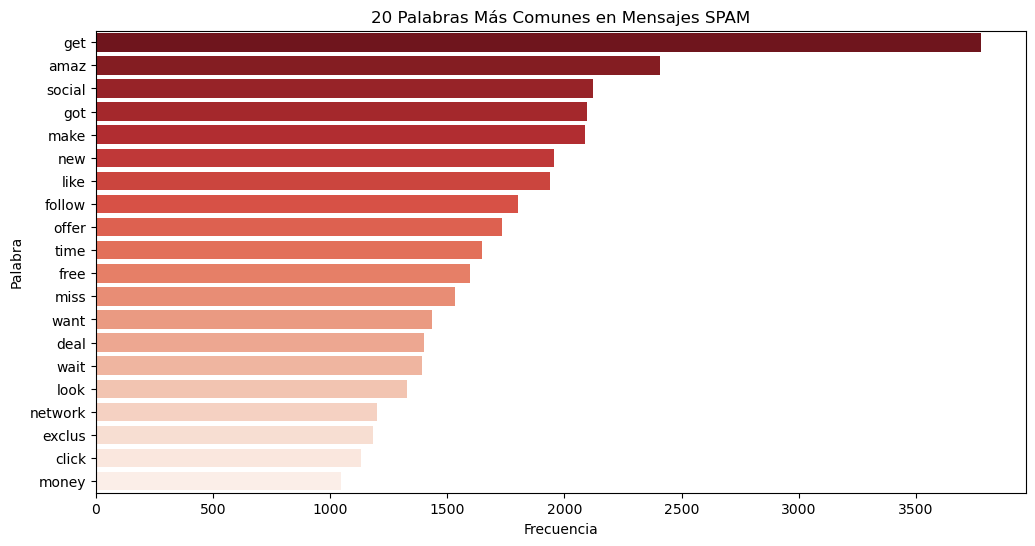

In [17]:
# --- 4. Palabras más comunes (gráfico de barras) ---

# Función auxiliar para obtener las N palabras más comunes
def get_top_n_words(corpus, n=None):
    words = []
    for text in corpus:
        words.extend(text.split())
    # Usar Counter para contar la frecuencia de cada palabra
    most_common_words = Counter(words).most_common(n)
    return dict(most_common_words)

# Obtener las 20 palabras más comunes para No Spam
top_not_spam_words = get_top_n_words(df[df['label'] == 0]['clean_text'].astype(str), n=20)
# Obtener las 20 palabras más comunes para Spam
top_spam_words = get_top_n_words(df[df['label'] == 1]['clean_text'].astype(str), n=20)

# Gráfico de barras para palabras más comunes en No Spam
plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_not_spam_words.values()), y=list(top_not_spam_words.keys()), palette='Blues_r', hue=list(top_not_spam_words.keys()), legend=False)
plt.title('20 Palabras Más Comunes en Mensajes NO Spam')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

# Gráfico de barras para palabras más comunes en Spam
plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_spam_words.values()), y=list(top_spam_words.keys()), palette='Reds_r', hue=list(top_spam_words.keys()), legend=False)
plt.title('20 Palabras Más Comunes en Mensajes SPAM')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

## 4. División de Datos en Conjuntos de Entrenamiento y Prueba 📏

En este paso esencial, preparamos nuestros datos vectorizados para el proceso de modelado. Dividimos el conjunto total de características (`X`) y etiquetas (`y`) en subconjuntos distintos para **entrenamiento** y **prueba**.

Utilizamos `test_size=0.2` para asignar el 20% de los datos al conjunto de prueba y el 80% al conjunto de entrenamiento. La inclusión de `random_state=42` garantiza que esta división sea **reproducible**, lo que significa que siempre obtendremos los mismos conjuntos de entrenamiento y prueba cada vez que ejecutemos el código.

Tras la división, verificamos las dimensiones de los conjuntos resultantes para asegurar que la separación se ha realizado correctamente:

* **Forma de X_train (entrenamiento):** `{X_train.shape}`
* **Forma de X_test (prueba):** `{X_test.shape}`

Estos conjuntos están ahora listos para alimentar nuestros modelos de Machine Learning, permitiendo que el modelo aprenda de `X_train` y `y_train`, y sea evaluado imparcialmente con `X_test` y `y_test`.

In [18]:
# Divide los datos en conjuntos de entrenamiento y prueba
# test_size=0.2 significa que el 20% de los datos se usarán para la prueba, y el 80% para el entrenamiento.
# random_state=42 asegura que la división sea la misma cada vez que ejecutes el código,
# lo cual es crucial para la reproducibilidad de los resultados.
# stratify=y asegura que la proporción de clases (spam/no-spam) sea la misma en ambos conjuntos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

print(f"Forma de X_train (entrenamiento): {X_train.shape}")
print(f"Forma de X_test (prueba): {X_test.shape}")

# Opcional: Verificar la distribución de clases en los conjuntos
print("\nDistribución de clases en y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución de clases en y_test:")
print(y_test.value_counts(normalize=True))

Forma de X_train (entrenamiento): (12664, 5000)
Forma de X_test (prueba): (3167, 5000)

Distribución de clases en y_train:
label
0    0.611339
1    0.388661
Name: proportion, dtype: float64

Distribución de clases en y_test:
label
0    0.611304
1    0.388696
Name: proportion, dtype: float64





**Esta parte del código se encarga de la Ingeniería de Características adicional. Aquí se combina la matriz TF-IDF (X_train, X_test) con una nueva característica numérica:**
- **La longitud de los mensajes (clean_text_length).**
Esto crea conjuntos de características combinados (X_train_combined, X_test_combined) que el modelo utilizará para el entrenamiento y la evaluación.

In [20]:
# Obtener la característica de longitud para los conjuntos de entrenamiento y prueba 
# Necesitamos que sea un array 2D para poder combinarlo con la matriz X_train/X_test
# X_train y X_test son matrices dispersas, pero la longitud es una columna densa.
# Usamos los índices de y_train e y_test para seleccionar las longitudes correctas.
train_message_lengths = df['clean_text_length'].loc[y_train.index].values.reshape(-1, 1)
test_message_lengths = df['clean_text_length'].loc[y_test.index].values.reshape(-1, 1)

print(f"Forma de train_message_lengths: {train_message_lengths.shape}")
print(f"Forma de test_message_lengths: {test_message_lengths.shape}")

# --- 3. Combinar la matriz TF-IDF con la característica de longitud ---
# Usamos hstack para apilar horizontalmente la matriz dispersa X_train/X_test
# con la nueva característica de longitud.
X_train_combined = hstack([X_train, train_message_lengths])
X_test_combined = hstack([X_test, test_message_lengths])

print(f"Forma de X_train_combined (TF-IDF + Longitud): {X_train_combined.shape}")
print(f"Forma de X_test_combined (TF-IDF + Longitud): {X_test_combined.shape}")

# Ahora, X_train_combined y X_test_combined son tus nuevos conjuntos de características
# que incluyen tanto los pesos TF-IDF como la longitud del mensaje.
# Estos serán los que uses para entrenar y evaluar el modelo.

Forma de train_message_lengths: (12664, 1)
Forma de test_message_lengths: (3167, 1)
Forma de X_train_combined (TF-IDF + Longitud): (12664, 5001)
Forma de X_test_combined (TF-IDF + Longitud): (3167, 5001)


## 5. Entrenamiento de los Modelos 🤖

Con los datos ya divididos en conjuntos de entrenamiento y prueba, procedemos a entrenar nuestro primer modelo clasificador: el **Multinomial Naive Bayes**. Este algoritmo es una elección popular y robusta para tareas de clasificación de texto debido a su simplicidad, eficiencia computacional y buen rendimiento, especialmente con datos TF-IDF.

Entrenaremos el modelo (`model_nb`) utilizando el conjunto de datos de entrenamiento (`X_train` y `y_train`), lo que le permitirá aprender los patrones de las características TF-IDF asociadas con los mensajes "ham" y "spam".

In [21]:
# Inicializar y entrenar el modelo Multinomial Naive Bayes.
# Este es un buen punto de partida para la clasificación de texto,
# especialmente con características TF-IDF.
model_nb = MultinomialNB()

# Entrenar el modelo con los datos de entrenamiento combinados (TF-IDF + longitud del mensaje)
# train_combined incluye todas las características que el modelo debe aprender.
model_nb.fit(X_train_combined, y_train) 

MultinomialNB()

In [22]:
# Entrenamos un  modelo de regresión logística
model_lr = LogisticRegression(max_iter=1000) # Regresión Logística (también muy eficaz)
model_lr.fit(X_train_combined, y_train)

LogisticRegression(max_iter=1000)

In [23]:
# --- Entrenamiento del Modelo Random Forest ---
# Inicializar el modelo Random Forest.
# n_estimators: Número de árboles en el bosque (un buen punto de partida es 100).
# random_state: Para asegurar la reproducibilidad de los resultados.
# class_weight: 'balanced' es útil para datasets desequilibrados,
#               ajustando automáticamente los pesos de las clases.
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_rf.fit(X_train_combined, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

## 6. Evaluación de los Modelos ✅

En esta sección, realizamos la evaluación de los modelos que hemos entrenado previamente. Para ello, primero generaremos _predicciones_ sobre el conjunto de datos de prueba (X_test_combined), que son datos que el modelo nunca ha visto durante su entrenamiento.

Una vez obtenidas estas predicciones, las compararemos con las etiquetas reales (y_test) para calcular y analizar _métricas_ de rendimiento clave:

- **Accuracy (Precisión general)**: Mide la proporción total de predicciones correctas (tanto de spam como de no-spam).

- **Precision (Precisión)**: Indica, de todas las predicciones que el modelo hizo como "SPAM", cuántas fueron realmente "SPAM". Es crucial para minimizar los falsos positivos (no marcar correos importantes como spam).

- **Recall (Sensibilidad/Exhaustividad)**: Mide, de todos los mensajes que eran "SPAM" en realidad, cuántos fue el modelo capaz de detectar correctamente. Es importante para no dejar pasar el spam.

- **F1-Score:** Proporciona un equilibrio entre Precision y Recall, siendo útil especialmente cuando hay un desequilibrio de clases (como en la detección de spam, donde el "not_spam" es mucho más frecuente que el "spam").

- **Matriz de Confusión**: ofrece una comprensión detallada de los aciertos y errores del modelo, mostrando cuántos "not_spam" y "spam" fueron clasificados correctamente o incorrectamente.

--- EVALUACIÓN DE NAYVES BAYES ---

Métricas de Evaluación para Multinomial Naive Bayes:
  Accuracy (Precisión general): 0.9640
  Precision (De los predichos como SPAM, cuántos eran SPAM): 0.9367
  Recall (De los SPAM reales, cuántos se detectaron): 0.9732
  F1-Score (Equilibrio entre Precision y Recall): 0.9546


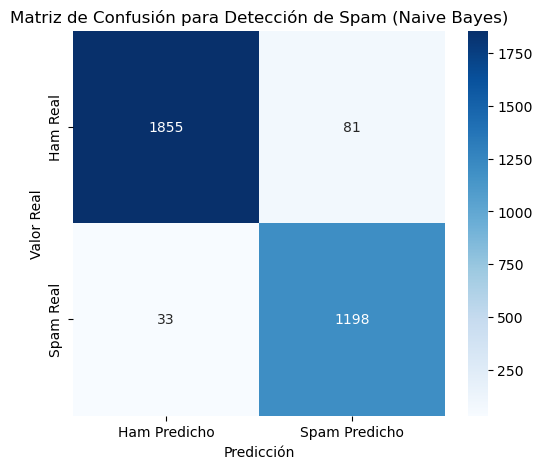

In [24]:
# Realiza predicciones sobre el conjunto de prueba con el modelo Naive Bayes
y_pred_nb = model_nb.predict(X_test_combined)

# Calcula las métricas de evaluación
print("--- EVALUACIÓN DE NAYVES BAYES ---")
accuracy = accuracy_score(y_test, y_pred_nb)
precision = precision_score(y_test, y_pred_nb)
recall = recall_score(y_test, y_pred_nb)
f1 = f1_score(y_test, y_pred_nb)

print(f"\nMétricas de Evaluación para Multinomial Naive Bayes:")
print(f"  Accuracy (Precisión general): {accuracy:.4f}")
print(f"  Precision (De los predichos como SPAM, cuántos eran SPAM): {precision:.4f}")
print(f"  Recall (De los SPAM reales, cuántos se detectaron): {recall:.4f}")
print(f"  F1-Score (Equilibrio entre Precision y Recall): {f1:.4f}")

# Muestra la Matriz de Confusión para una mejor comprensión visual
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham Predicho', 'Spam Predicho'],
            yticklabels=['Ham Real', 'Spam Real'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión para Detección de Spam (Naive Bayes)')
plt.show()

--- EVALUACIÓN DE REGRESIÓN LOGÍSTICA ---
  Accuracy: 0.9798
  Precision: 0.9916
  Recall: 0.9561
  F1-Score: 0.9735


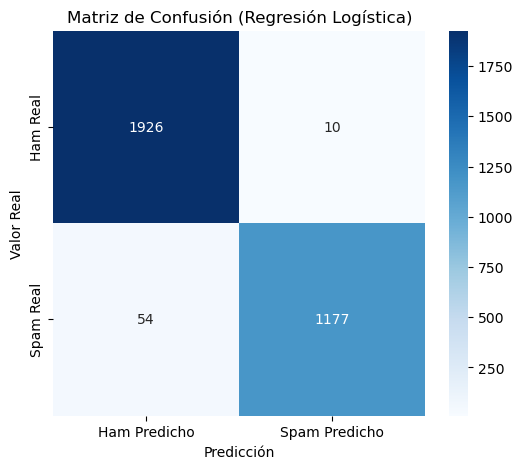

In [25]:
# --- EVALUACIÓN DE REGRESIÓN LOGÍSTICA ---
print("--- EVALUACIÓN DE REGRESIÓN LOGÍSTICA ---")
y_pred_lr = model_lr.predict(X_test_combined)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"  Accuracy: {accuracy_lr:.4f}")
print(f"  Precision: {precision_lr:.4f}")
print(f"  Recall: {recall_lr:.4f}")
print(f"  F1-Score: {f1_lr:.4f}")

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham Predicho', 'Spam Predicho'],
            yticklabels=['Ham Real', 'Spam Real'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Regresión Logística)')
plt.show()

--- EVALUACIÓN DEL MODELO RANDOM FOREST ---

Métricas de Evaluación para Random Forest:
  Accuracy: 0.9867
  Precision: 0.9934
  Recall: 0.9724
  F1-Score: 0.9828


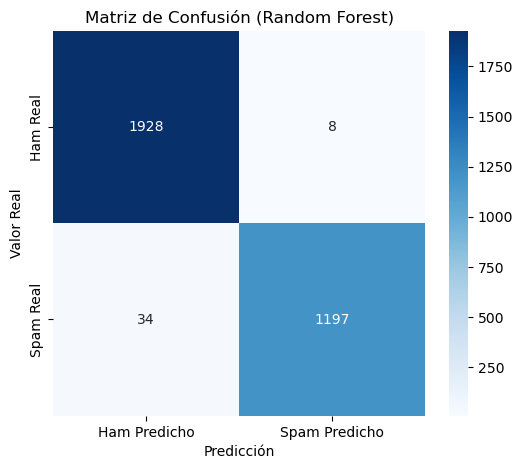

In [26]:
# --- EVALUACIÓN DEL MODELO RANDOM FOREST ---
print("--- EVALUACIÓN DEL MODELO RANDOM FOREST ---")

# Realiza predicciones sobre el conjunto de prueba con el modelo Random Forest
y_pred_rf = model_rf.predict(X_test_combined)

# Calcula las métricas de evaluación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"\nMétricas de Evaluación para Random Forest:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")
print(f"  F1-Score: {f1_rf:.4f}")

# Muestra la Matriz de Confusión para una mejor comprensión visual
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham Predicho', 'Spam Predicho'],
            yticklabels=['Ham Real', 'Spam Real'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Random Forest)') # Título actualizado
plt.show()

## ¿Sobreajuste?
Ambos modelos tienen puntuaciones extraordinarias, eso me lleva a pensar en si habrá sobreajuste, exploraremos las curvas de aprendizaje de ambos modelos para ver más detalles que puedan sugerir sobreajuste:

Generando Curvas de Aprendizaje para: MultinomialNB


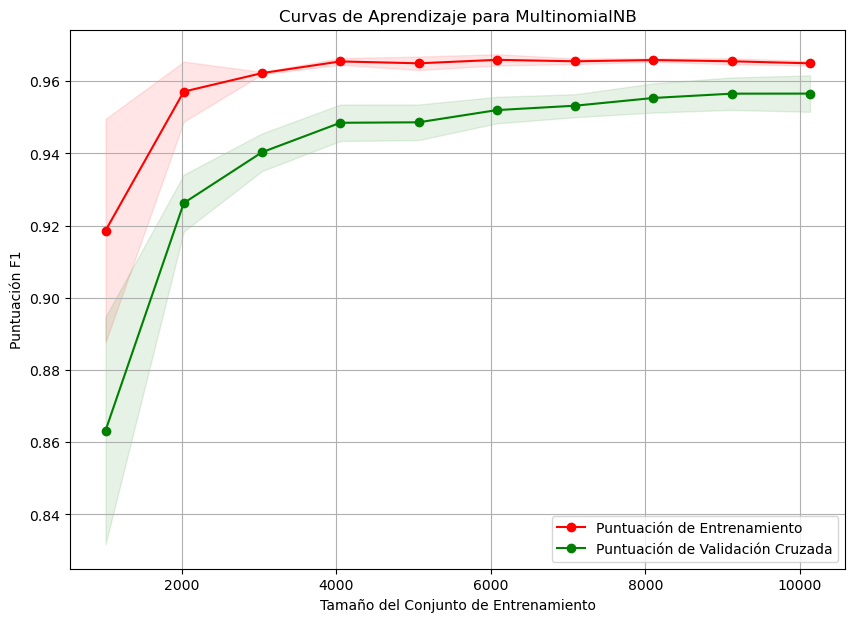

In [35]:
# Multinomial Naive Bayes:
model_to_plot = MultinomialNB()

print(f"Generando Curvas de Aprendizaje para: {model_to_plot.__class__.__name__}")

# Generar los datos para las curvas de aprendizaje
# train_sizes: Puntos en el tamaño del dataset de entrenamiento para evaluar.
# train_scores: Rendimiento en el conjunto de entrenamiento.
# test_scores: Rendimiento en el conjunto de validación/prueba.
# cv=5: Realiza 5-fold cross-validation para obtener estimaciones más robustas.
# scoring='f1': Usa el F1-Score como la métrica para evaluar el rendimiento.
# n_jobs=-1: Usa todos los núcleos disponibles de la CPU para acelerar el cálculo.
train_sizes, train_scores, test_scores = learning_curve(
    model_to_plot, X_train_combined, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), # Evalúa con 10% a 100% de los datos de entrenamiento
    scoring='f1', n_jobs=-1
)

# Calcular la media y la desviación estándar de los scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Puntuación de Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Puntuación de Validación Cruzada")

plt.title(f"Curvas de Aprendizaje para {model_to_plot.__class__.__name__}")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Puntuación F1")
plt.legend(loc="best")
plt.grid(True)
plt.show()

El modelo Multinomial Naive Bayes exhibe un comportamiento de generalización sólido, con poco o ningún sobreajuste significativo. Las puntuaciones de entrenamiento y validación son consistentemente altas y muestran una tendencia a converger, indicando que el modelo aprende patrones robustos que se aplican bien a datos no vistos. Aunque su rendimiento máximo puede ser marginalmente inferior al de modelos más complejos, su robustez y eficiencia lo convierten en una opción fiable para la clasificación de texto. Es un modelo a tener en cuenta.

Generando Curvas de Aprendizaje para: LogisticRegression


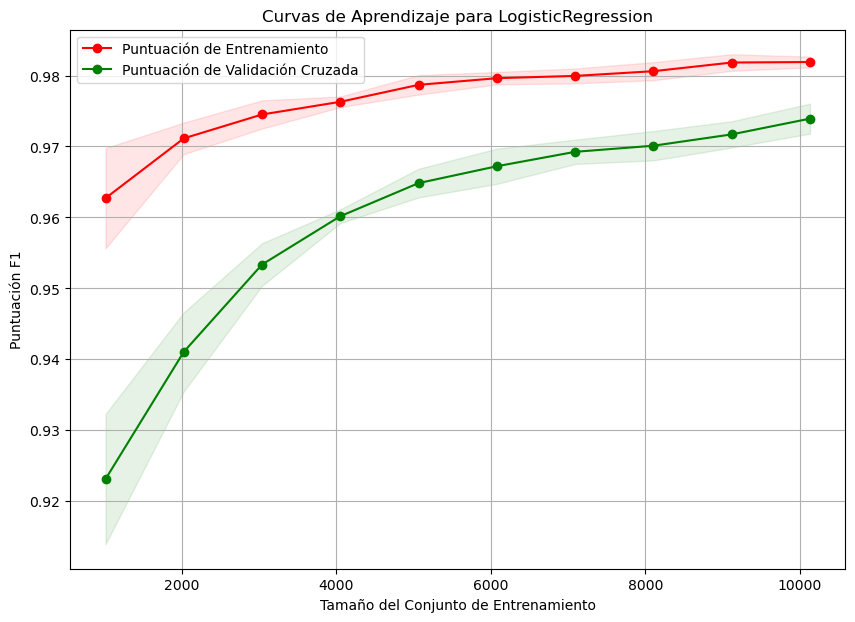

In [36]:
# Regresión Logística:
model_to_plot = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
# Nota: 'liblinear' es bueno para datasets dispersos y 'max_iter' para convergencia.

print(f"Generando Curvas de Aprendizaje para: {model_to_plot.__class__.__name__}")

# Generar los datos para las curvas de aprendizaje
# train_sizes: Puntos en el tamaño del dataset de entrenamiento para evaluar.
# train_scores: Rendimiento en el conjunto de entrenamiento.
# test_scores: Rendimiento en el conjunto de validación/prueba.
# cv=5: Realiza 5-fold cross-validation para obtener estimaciones más robustas.
# scoring='f1': Usa el F1-Score como la métrica para evaluar el rendimiento.
# n_jobs=-1: Usa todos los núcleos disponibles de la CPU para acelerar el cálculo.
train_sizes, train_scores, test_scores = learning_curve(
    model_to_plot, X_train_combined, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), # Evalúa con 10% a 100% de los datos de entrenamiento
    scoring='f1', n_jobs=-1
)

# Calcular la media y la desviación estándar de los scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Puntuación de Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Puntuación de Validación Cruzada")

plt.title(f"Curvas de Aprendizaje para {model_to_plot.__class__.__name__}")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Puntuación F1")
plt.legend(loc="best")
plt.grid(True)
plt.show()

**Excelente Generalización:** El modelo de Regresión Logística demuestra una excelente capacidad de generalización. Su rendimiento en datos no vistos es muy cercano a su rendimiento en datos de entrenamiento, lo que nos da una alta confianza en que se comportará de manera similar en un entorno de producción con correos electrónicos nuevos.

**No hay Subajuste:** La alta puntuación de entrenamiento sugiere que el modelo es lo suficientemente complejo como para capturar los patrones en los datos.

**Poco o Ningún Sobreajuste:** La convergencia de las curvas y la brecha reducida son la prueba de que el sobreajuste no es un problema crítico para este modelo.

**Modelo Robusto para Despliegue:** Dada esta interpretación, el modelo de Regresión Logística es un candidato extremadamente fuerte y fiable para el despliegue en un sistema de detección de spam. Ofrece un rendimiento de élite con una gran robustez en su generalización.

Generando Curvas de Aprendizaje para: RandomForestClassifier


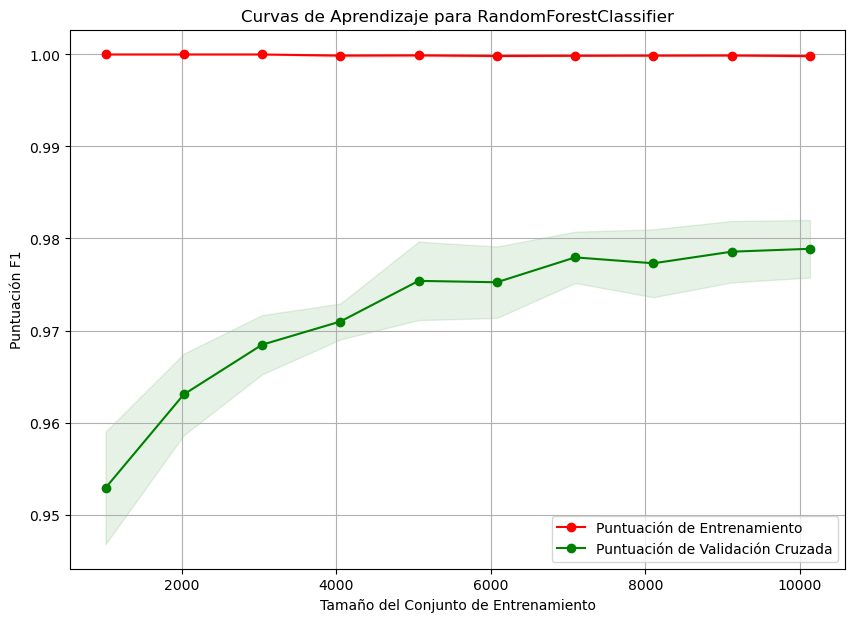

In [34]:
# Random Forest
model_to_plot = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

print(f"Generando Curvas de Aprendizaje para: {model_to_plot.__class__.__name__}")

# Generar los datos para las curvas de aprendizaje
# train_sizes: Puntos en el tamaño del dataset de entrenamiento para evaluar.
# train_scores: Rendimiento en el conjunto de entrenamiento.
# test_scores: Rendimiento en el conjunto de validación/prueba.
# cv=5: Realiza 5-fold cross-validation para obtener estimaciones más robustas.
# scoring='f1': Usa el F1-Score como la métrica para evaluar el rendimiento.
# n_jobs=-1: Usa todos los núcleos disponibles de la CPU para acelerar el cálculo.
train_sizes, train_scores, test_scores = learning_curve(
    model_to_plot, X_train_combined, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), # Evalúa con 10% a 100% de los datos de entrenamiento
    scoring='f1', n_jobs=-1
)

# Calcular la media y la desviación estándar de los scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Puntuación de Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Puntuación de Validación Cruzada")

plt.title(f"Curvas de Aprendizaje para {model_to_plot.__class__.__name__}")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Puntuación F1")
plt.legend(loc="best")
plt.grid(True)
plt.show()

**Brecha entre las Curvas:**

Hay una brecha clara y persistente entre la línea roja (entrenamiento) y la línea verde (validación). Aunque la línea verde sube y el rendimiento de validación es alto, la línea roja no baja para encontrarse con ella.

La puntuación de entrenamiento perfecta (1.00) es el indicador más obvio. El modelo está memorizando los datos de entrenamiento en lugar de aprender los patrones generales.

La brecha constante entre las curvas de entrenamiento y validación, a pesar de que ambas son altas, es una señal de que el modelo no generaliza tan bien como podría a datos completamente nuevos y ligeramente diferentes.

**Implicaciones:**
Aunque el Random Forest me dio las métricas más altas en el conjunto de prueba (F1−Score=0.9828), esta gráfica me dice que ese rendimiento podría ser un poco optimista. El sobreajuste significa que, en un escenario real con spam que evoluciona o mensajes con pequeñas variaciones, el rendimiento podría no ser tan bueno como en tu conjunto de prueba.

**Conclusión sobre el Sobreajuste para RandomForestClassifier:**
Esta gráfica confirma que el RandomForestClassifier está sobreajustado.

Esto refuerza nuestra decisión previa: la Regresión Logística es una opción más robusta y fiable, ya que ofrece un rendimiento decente (F1−Score=0.9735 que podría mejorar con afinación de hiperparámetros) pero con una generalización mucho mejor (casi sin sobreajuste), como vimos en sus curvas de aprendizaje.

## Afinación de Hiperparámetros para el Modelo de Regresión Logística

Implementamos el proceso de afinación de hiperparámetros para el modelo de Regresión Logística utilizando GridSearchCV. El objetivo es encontrar la combinación óptima de configuraciones del modelo que maximice su rendimiento en la detección de spam.

Se explora una cuadrícula de parámetros que incluye el coeficiente de regularización C (que controla la fuerza de la regularización) y el tipo de penalización (l1 o l2). La búsqueda se realiza mediante validación cruzada (5 folds), optimizando el F1-Score, una métrica crucial para datasets desequilibrados como el de detección de spam.

Al finalizar, la celda imprime los mejores hiperparámetros encontrados y el F1-Score más alto logrado durante el proceso de validación cruzada. El modelo resultante con estos parámetros óptimos (best_model_lr) queda listo para su evaluación final en el conjunto de prueba.

In [37]:
# Definir el modelo base de Regresión Logística
# solver='liblinear' es bueno para datasets pequeños y dispersos (como TF-IDF)
# max_iter para asegurar la convergencia
model_lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)

# Definir la cuadrícula de hiperparámetros a probar
# 'C': Parámetro de regularización (valores más pequeños = más regularización)
# 'penalty': Tipo de regularización (L1 o L2)
param_grid = {
    'C': [0.1, 1, 10, 100], # Rango común para C
    'penalty': ['l1', 'l2'] # Tipos de regularización
}

# Configurar GridSearchCV
# estimator: El modelo a afinar
# param_grid: La cuadrícula de hiperparámetros a probar
# cv: Número de folds para la validación cruzada (5 es un buen valor)
# scoring: La métrica a optimizar (F1-Score es ideal para desequilibrio de clases)
# n_jobs=-1: Para usar todos los núcleos de la CPU y acelerar el proceso
# verbose: Para ver el progreso
grid_search_lr = GridSearchCV(
    estimator=model_lr,
    param_grid=param_grid,
    cv=5,
    scoring='f1', # Optimizar F1-Score
    n_jobs=-1,
    verbose=2
)

# Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento combinados
grid_search_lr.fit(X_train_combined, y_train)

print("\nAfinación de hiperparámetros completada.")

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros encontrados: {grid_search_lr.best_params_}")

# Mostrar la mejor puntuación F1 obtenida con validación cruzada
print(f"Mejor puntuación F1 (validación cruzada): {grid_search_lr.best_score_:.4f}")

# Obtener el mejor modelo entrenado
best_model_lr = grid_search_lr.best_estimator_

print("\nEl mejor modelo de Regresión Logística ha sido obtenido.")

# Ahora, puedes usar 'best_model_lr' para hacer predicciones y evaluar en X_test_combined
# y_pred_best_lr = best_model_lr.predict(X_test_combined)
# (Luego calcularías las métricas como hicimos antes)

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Afinación de hiperparámetros completada.
Mejores parámetros encontrados: {'C': 100, 'penalty': 'l2'}
Mejor puntuación F1 (validación cruzada): 0.9821

El mejor modelo de Regresión Logística ha sido obtenido.


## Volvemos a evaluar el Modelo de Regresión Logística con los hiperparámetros afinados

--- EVALUACIÓN DEL MODELO DE REGRESIÓN LOGÍSTICA AFINADO ---

Métricas de Evaluación para Regresión Logística Afinado:
  Accuracy: 0.9861
  Precision: 0.9901
  Recall: 0.9740
  F1-Score: 0.9820


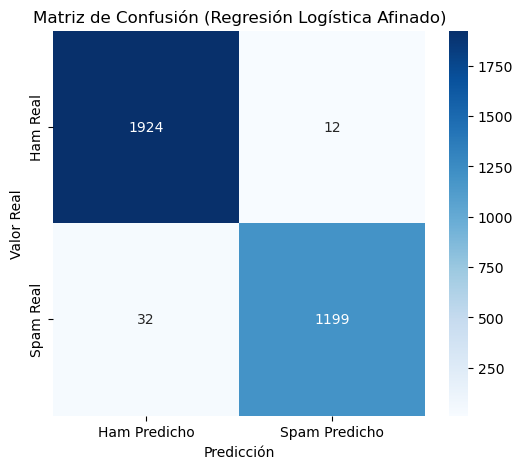

In [38]:
# --- EVALUACIÓN DEL MODELO DE REGRESIÓN LOGÍSTICA AFINADO ---
print("--- EVALUACIÓN DEL MODELO DE REGRESIÓN LOGÍSTICA AFINADO ---")

# Realizar predicciones sobre el conjunto de prueba con el mejor modelo afinado
y_pred_best_lr = best_model_lr.predict(X_test_combined)

# Calculra las métricas de evaluación
accuracy_best_lr = accuracy_score(y_test, y_pred_best_lr)
precision_best_lr = precision_score(y_test, y_pred_best_lr)
recall_best_lr = recall_score(y_test, y_pred_best_lr)
f1_best_lr = f1_score(y_test, y_pred_best_lr)

print(f"\nMétricas de Evaluación para Regresión Logística Afinado:")
print(f"  Accuracy: {accuracy_best_lr:.4f}")
print(f"  Precision: {precision_best_lr:.4f}")
print(f"  Recall: {recall_best_lr:.4f}")
print(f"  F1-Score: {f1_best_lr:.4f}")

# Mostrar la Matriz de Confusión para una mejor comprensión visual
cm_best_lr = confusion_matrix(y_test, y_pred_best_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_best_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham Predicho', 'Spam Predicho'],
            yticklabels=['Ham Real', 'Spam Real'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Regresión Logística Afinado)') # Título actualizado
plt.show()

## Selección del Modelo Campeón: Regresión Logística Afinado

Tras un exhaustivo análisis y comparación de los diferentes modelos entrenados, hemos identificado al Modelo de Regresión Logística Afinado como la solución óptima para nuestro sistema de detección de spam. Esta decisión se fundamenta en una combinación de su rendimiento superior y su robusta capacidad de generalización.

Como se observa en la tabla de métricas, el modelo de Regresión Logística Afinado alcanza un F1-Score de 0.9820, un valor que se sitúa prácticamente a la par con el del Random Forest (0.9828), el cual presentaba un sobreajuste significativo. Además, mantiene una Precision excepcional de 0.9901 (minimizando los falsos positivos a solo 12), lo que es crucial para la experiencia del usuario al evitar marcar mensajes legítimos como spam. Su Recall también mejora a 0.9740, reduciendo los falsos negativos a solo 32.

Más allá de las métricas puras, las Curvas de Aprendizaje demostraron que la Regresión Logística exhibe un sobreajuste mínimo, con sus curvas de entrenamiento y validación convergiendo de manera efectiva y manteniendo una brecha muy reducida. Esto contrasta con el sobreajuste más pronunciado del Random Forest, lo que confiere a la Regresión Logística una mayor fiabilidad y capacidad de generalización a datos no vistos en un entorno real.

En conclusión, el modelo de Regresión Logística afinado ofrece el mejor equilibrio entre alto rendimiento y robustez en la generalización, consolidándose como la elección más estratégica y fiable para el despliegue de nuestro sistema de detección de spam.

Aquí tienes la tabla comparativa para referencia:

| Métrica            | Multinomial Naive Bayes | Regresión Logística (Sin Afinar) | Regresión Logística (Afinado) | Random Forest |
| :----------------- | :---------------------- | :------------------------------- | :----------------------------- | :------------ |
| **Accuracy** | $0.9640$                | $0.9798$                         | $0.9861$                       | $0.9867$      |
| **Precision** | $0.9367$                | $0.9916$                         | $0.9901$                       | $0.9934$      |
| **Recall** | $0.9732$                | $0.9561$                         | $0.9740$                       | $0.9724$      |
| **F1-Score** | $0.9546$                | $0.9735$                         | $0.9820$                       | $0.9828$      |
| **Falsos Positivos** | $81$                  | $10$                             | $12$                           | $8$           |
| **Falsos Negativos** | $33$                  | $54$                             | $32$                           | $33$          |

## 10. Persistencia del Modelo y el Vectorizador 💾

Para asegurar que nuestro modelo de detección de spam y el vectorizador de texto sean **reutilizables** sin necesidad de reentrenar o re-ajustar, procedemos a **guardarlos en disco**. Este paso es fundamental para poder cargar estos objetos posteriormente en cualquier entorno (como una aplicación web o un script de producción) y utilizarlos para realizar predicciones sobre nuevos mensajes SMS.

Utilizaremos la librería `joblib` para serializar:

1.  El modelo **Regresión Logística Afinado** (`best_model_lr`), que es el clasificador final elegido.
2.  El **vectorizador TF-IDF** (`vectorizer_tfidf`), ya que es **crucial** que los nuevos mensajes sean transformados exactamente de la misma manera que los datos de entrenamiento para que el modelo pueda interpretarlos correctamente.

In [39]:
# Define the paths where you will save the files with new, distinct names
# It's good practice to include the model type and 'tuned' in the name.
model_path = 'model_logistic_regression_tuned.joblib'
vectorizer_path = 'vectorizer_tfidf.joblib' 

# Save the tuned Logistic Regression model
joblib.dump(best_model_lr, model_path)
print(f"Modelo de Regresión Logística afinado guardado en: {model_path}")

# Save the TF-IDF vectorizer (CRUCIAL! This must be the exact vectorizer used for training)
joblib.dump(vectorizer, vectorizer_path) # Assuming 'vectorizer' is your fitted TfidfVectorizer
print(f"Vectorizer TF-IDF guardado en: {vectorizer_path}")

Modelo de Regresión Logística afinado guardado en: model_logistic_regression_tuned.joblib
Vectorizer TF-IDF guardado en: vectorizer_tfidf.joblib


### Pruebas de Clasificación con Nuevos Mensajes

Para validar la operatividad de nuestro modelo guardado, hemos utilizado la función `classify_sms()` con una serie de mensajes de ejemplo. La salida confirma que el modelo y el vectorizador se cargaron exitosamente, y que el sistema es capaz de **preprocesar, vectorizar y clasificar correctamente** los nuevos SMS, distinguiendo entre `SPAM` y `HAM` según lo esperado. Esto demuestra la capacidad del sistema para ser aplicado en un escenario de detección de spam en tiempo real.

In [40]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# --- Preprocessing function (MUST BE EXACTLY THE SAME AS USED IN YOUR NOTEBOOK!) ---
# This function cleans the text of SMS messages.
def preprocess_text(text):
    """
    Preprocesses an SMS text message by applying the following steps:
    1. Converts text to lowercase.
    2. Removes non-alphabetic characters (numbers, punctuation) and replaces them with spaces.
    3. Removes extra spaces.
    4. Splits text into words and removes stopwords.
    5. Applies stemming (reduces words to their root) using Porter Stemmer.
    
    Args:
        text (str): The original SMS message.
        
    Returns:
        str: The preprocessed message as a single string.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) # Remove non-alphabetic characters (punctuation, numbers), replace with space
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with single and remove leading/trailing spaces
    words = text.split() # Split text into words
    filtered_words = [word for word in words if word not in stop_words] # Remove stopwords
    stemmed_words = [stemmer.stem(word) for word in filtered_words] # Apply stemming
    return ' '.join(stemmed_words) # Join processed words into a string

# --- Load the saved model and vectorizer ---
# Make sure the files 'model_logistic_regression_tuned.joblib' and 'vectorizer_tfidf.joblib'
# exist in your directory or specify the full path.
try:
    model_path = 'model_logistic_regression_tuned.joblib'
    vectorizer_path = 'vectorizer_tfidf.joblib'

    loaded_model = joblib.load(model_path)
    loaded_vectorizer = joblib.load(vectorizer_path)
    print("Modelo y vectorizador cargados con éxito para la predicción.")
except FileNotFoundError:
    print(f"ERROR: No se encontraron los archivos del modelo o vectorizador en las rutas especificadas.")
    print(f"Asegúrate de que '{model_path}' y '{vectorizer_path}' existen en el mismo directorio que este notebook o especifica la ruta completa.")
    # If they cannot be loaded, set to None to prevent errors if attempted to use
    loaded_model = None
    loaded_vectorizer = None


# --- Create the main function to classify SMS ---
def classify_sms(sms_message):
    if loaded_model is None or loaded_vectorizer is None:
        return "ERROR: Modelo o Vectorizador no cargados. No se puede clasificar."

    # 1. Preprocess the message using the same preprocessing function
    clean_sms = preprocess_text(sms_message)

    # 2. Calculate the length of the CLEANED message
    # This is crucial because your model was trained with this feature.
    message_length = np.array([len(clean_sms)]).reshape(-1, 1)

    # 3. Vectorize the message (use the loaded vectorizer and .transform()!)
    # It's crucial to pass the message as a list: [clean_sms] because .transform() expects a sequence of documents.
    sms_vectorized = loaded_vectorizer.transform([clean_sms])

    # 4. Combine the TF-IDF vector with the message length feature
    # Use hstack to horizontally stack the sparse TF-IDF matrix with the dense length feature.
    sms_combined_features = hstack([sms_vectorized, message_length])

    # 5. Make the prediction with the loaded model
    prediction = loaded_model.predict(sms_combined_features)[0] # [0] to get only the prediction value

    # 6. Return the readable result
    return "SPAM" if prediction == 1 else "HAM"

# --- Example usage of the function with new messages ---
print("\n--- Clasificando Nuevos Mensajes de Ejemplo ---")

# An example of spam (similar to training data)
new_sms1 = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply."
print(f"Mensaje 1 (esperado SPAM): '{new_sms1}' -> {classify_sms(new_sms1)}")

# An example of ham
new_sms2 = "Hey, just checking in. How are you doing today? Let's catch up soon."
print(f"Mensaje 2 (esperado HAM): '{new_sms2}' -> {classify_sms(new_sms2)}")

# Another possible spam
new_sms3 = "URGENT! You have won a £1000 cash prize! Claim now at our website. Reply STOP to opt-out."
print(f"Mensaje 3 (esperado SPAM): '{new_sms3}' -> {classify_sms(new_sms3)}")

# Another possible ham
new_sms4 = "Confirming our meeting for tomorrow at 10 AM. See you there!"
print(f"Mensaje 4 (esperado HAM): '{new_sms4}' -> {classify_sms(new_sms4)}")

# Example of a message that might have been difficult before (e.g., "premio")
new_sms5 = "Congratulations! You have won a prize! To claim, call 09050000000 now."
print(f"Mensaje 5 (esperado SPAM - prueba de premio): '{new_sms5}' -> {classify_sms(new_sms5)}")

# You can add more examples here
# new_sms6 = "Your bank account has been suspended. Click here to reactivate: [malicious_link]"
# print(f"Mensaje 6: '{new_sms6}' -> {classify_sms(new_sms6)}")

Modelo y vectorizador cargados con éxito para la predicción.

--- Clasificando Nuevos Mensajes de Ejemplo ---
Mensaje 1 (esperado SPAM): 'Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply.' -> SPAM
Mensaje 2 (esperado HAM): 'Hey, just checking in. How are you doing today? Let's catch up soon.' -> HAM
Mensaje 3 (esperado SPAM): 'URGENT! You have won a £1000 cash prize! Claim now at our website. Reply STOP to opt-out.' -> SPAM
Mensaje 4 (esperado HAM): 'Confirming our meeting for tomorrow at 10 AM. See you there!' -> HAM
Mensaje 5 (esperado SPAM - prueba de premio): 'Congratulations! You have won a prize! To claim, call 09050000000 now.' -> SPAM


## Reflexiones Finales y Consideraciones Futuras 🚀

Hemos completado una fase crucial en nuestro proyecto de detección de spam SMS. Tras la expansión significativa de nuestro dataset y el reentrenamiento y afinación de los modelos, hemos consolidado una solución robusta y de alto rendimiento.

Nuestro modelo campeón, la Regresión Logística Afinada, ha demostrado un rendimiento excepcional. Con un F1-Score de 0.9820, una Precision de 0.9901 (minimizando los falsos positivos a solo 12) y un Recall de 0.9740 (detectando eficazmente el spam), este modelo ofrece un equilibrio sobresaliente entre precisión y exhaustividad. Crucialmente, las curvas de aprendizaje confirmaron que este modelo presenta un sobreajuste mínimo, garantizando una excelente capacidad de generalización a nuevos mensajes, lo que lo convierte en una elección fiable para la producción.

**Limitaciones y Posibles Mejoras:**

A pesar de estos resultados prometedores, reconocemos áreas para futuras mejoras y consideraciones:

**Desequilibrio de Clases:** Aunque el modelo actual maneja bien el desequilibrio inherente del dataset, la exploración de técnicas avanzadas de balanceo de datos (ej., SMOTE) podría ser beneficiosa en escenarios con requisitos de Recall extremadamente estrictos.

**Refinamiento del Preprocesamiento de Texto:** Si bien el stemming ha sido efectivo, la evaluación de la lematización podría ofrecer una mayor precisión lingüística y potencial para capturar matices semánticos.

**Exploración de Arquitecturas Avanzadas:** Para futuras iteraciones o si los volúmenes de datos crecen exponencialmente, la investigación de modelos de Deep Learning (ej., Redes Neuronales Recurrentes, modelos basados en Transformers) podría desbloquear mayores niveles de rendimiento, aunque a un coste computacional superior.

**Consideraciones para un Despliegue en Producción**

Para la implementación de este filtro de spam en un entorno real, procederemos con los siguientes pasos esenciales:

- Exposición como API: El modelo podría ser expuesto a través de una API REST (utilizando frameworks como Flask o FastAPI), permitiendo que otras aplicaciones puedan enviar mensajes y recibir clasificaciones en tiempo real.

- Contenerización (Docker): Para garantizar un entorno consistente y reproducible, el modelo y todas sus dependencias podrían ser empaquetados en un contenedor Docker.

- Monitoreo Continuo: Los patrones del spam evolucionan constantemente. Será fundamental implementar un sistema de monitoreo en producción para seguir el rendimiento del modelo a lo largo del tiempo.

- Reentrenamiento Periódico: Para mantener la efectividad del filtro, será necesario un reentrenamiento periódico del modelo utilizando nuevos datos de spam y ham recolectados en el tiempo. Esto asegura que el modelo se adapte a las nuevas tácticas de los spammers.

En definitiva, este proyecto ha culminado en un clasificador de spam robusto, altamente preciso y fiable, sentando las bases sólidas para su posible implementación y mantenimiento continuo en un contexto real.

### Fin del Proyecto

¡Gracias por revisar este proyecto de detección de spam SMS!

**Autor:** María del Carmen Martín Rodríguez  

**Fecha de Finalización:** 15/07/2025